# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: E:\python_project\KTH_code\ID2223\Lab1\mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 23, 19, 9, 484192)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 23:19:09,561 INFO: Initializing external client
2025-11-18 23:19:09,563 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 23:19:10,869 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 23:19:16,596 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286321


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 23:19:21,055 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/440124 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120373 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19818 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.8458775E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-22 00:00:00+00:00,1.95,0.0,9.726664,218.990997,visby
1,2025-11-23 00:00:00+00:00,3.10,0.0,6.696387,233.746063,visby
2,2025-11-20 00:00:00+00:00,1.35,0.8,6.214563,100.007919,visby
3,2025-11-21 00:00:00+00:00,3.05,0.2,16.800856,315.000092,visby
4,2025-11-24 00:00:00+00:00,3.95,0.1,10.495713,67.833611,visby


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
)


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   predicted_pm25               5 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 308.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
2,2025-11-20 00:00:00+00:00,1.35,0.8,6.214563,100.007919,visby,27.074820,ostervag-17,sweden,3
3,2025-11-21 00:00:00+00:00,3.05,0.2,16.800856,315.000092,visby,12.566618,ostervag-17,sweden,4
0,2025-11-22 00:00:00+00:00,1.95,0.0,9.726664,218.990997,visby,38.359734,ostervag-17,sweden,1
1,2025-11-23 00:00:00+00:00,3.10,0.0,6.696387,233.746063,visby,48.693336,ostervag-17,sweden,2
4,2025-11-24 00:00:00+00:00,3.95,0.1,10.495713,67.833611,visby,14.969270,ostervag-17,sweden,5


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 2 to 4
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   predicted_pm25               5 non-null      float32                
 7   street                       5 non-null      object                 
 8   country                      5 non-null      object                 
 9   days_before_forecast_day     5 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 23:19:29,477 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



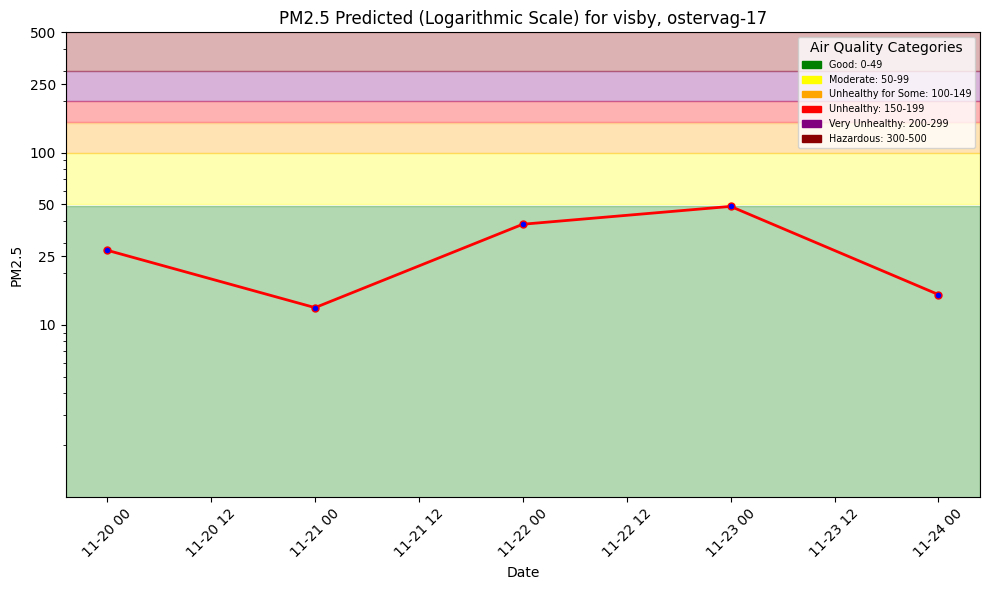

In [12]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286321/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 23:20:15,536 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 23:20:18,712 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:21:56,792 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 23:21:59,953 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:22:00,087 INFO: Waiting for log aggregation to finish.
2025-11-18 23:22:11,950 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [15]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,1.550000,0.0,3.600000,360.000000,visby,29.533037,ostervag-17,sweden,1
1,2025-11-18 00:00:00+00:00,2.350000,0.0,13.755580,263.991089,visby,37.466415,ostervag-17,sweden,1
2,2025-11-16 00:00:00+00:00,3.765084,0.3,21.366234,241.871948,visby,40.349968,ostervag-17,sweden,1
3,2025-11-15 00:00:00+00:00,2.535917,0.0,20.662399,291.608948,visby,19.539204,ostervag-17,sweden,1
4,2025-11-17 00:00:00+00:00,2.569250,4.7,19.172323,343.704407,visby,14.138197,ostervag-17,sweden,1
5,2025-11-22 00:00:00+00:00,1.950000,0.0,9.726664,218.990997,visby,38.359734,ostervag-17,sweden,1


In [16]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,date,pm25,country,city,street,url
0,2024-09-12 00:00:00+00:00,10.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987
1,2023-11-14 00:00:00+00:00,14.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987
2,2023-11-09 00:00:00+00:00,20.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987
3,2023-07-01 00:00:00+00:00,23.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987
4,2022-09-07 00:00:00+00:00,9.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987
...,...,...,...,...,...,...
1142,2024-12-23 00:00:00+00:00,36.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987
1143,2022-09-23 00:00:00+00:00,16.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987
1144,2023-07-03 00:00:00+00:00,23.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987
1145,2025-11-17 00:00:00+00:00,4.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987


In [17]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
2,2025-11-15 00:00:00+00:00,19.539204,7.0
1,2025-11-16 00:00:00+00:00,40.349968,6.0
3,2025-11-17 00:00:00+00:00,14.138197,4.0
0,2025-11-18 00:00:00+00:00,37.466415,11.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

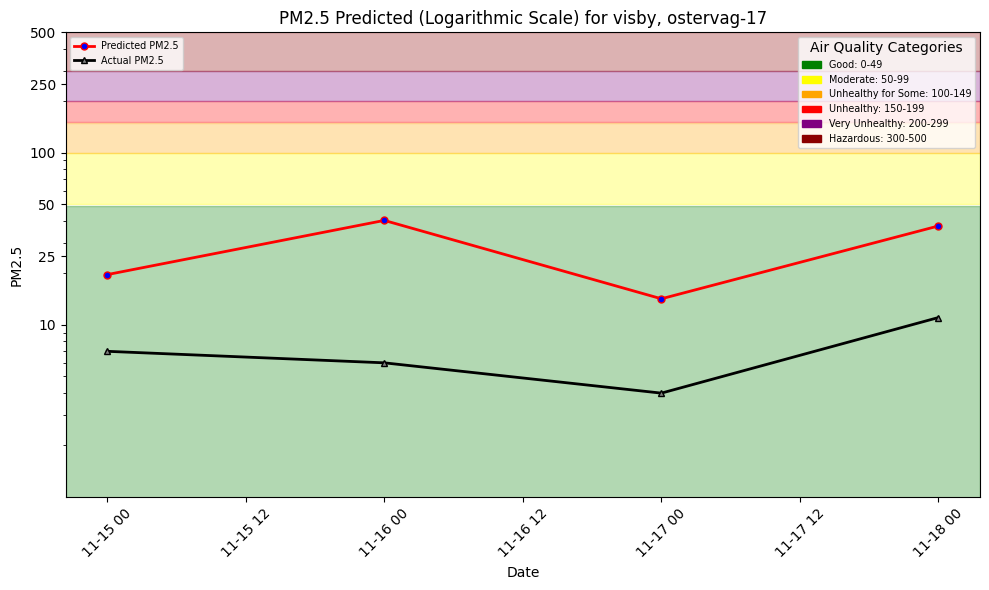

In [18]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [19]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading E:\python_project\KTH_code\ID2223\Lab1\mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.00…

Uploading E:\python_project\KTH_code\ID2223\Lab1\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png:…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286321/settings/fb/path/Resources/airquality


In [20]:
from xgboost import XGBRegressor

mr = project.get_model_registry()

retrieved_model_v2 = mr.get_model(
    name="air_quality_xgboost_model_v2",
    version=1
)

feature_view_v2 = retrieved_model_v2.get_feature_view()

retrieved_model_v2_dir = retrieved_model_v2.download()

retrieved_xgboost_model_v2 = XGBRegressor()
retrieved_xgboost_model_v2.load_model(retrieved_model_v2_dir + "/model_v2.json")

retrieved_xgboost_model_v2

2025-11-18 23:22:26,034 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/456005 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/119146 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27000 elapsed<00:00 remaining<?

XGBRegressor(base_score='2.8518559E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",
    version=2,
)
air_quality_df_v2=air_quality_fg_v2.read().sort_values("date")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


In [22]:
import datetime
import pandas as pd

feature_names = [
    'pm25_1d_ago',
    'pm25_2d_ago',
    'pm25_3d_ago',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant'
]
N_DAYS_TO_FORECAST = 7

today_date = today.date()
today_start_dt = datetime.datetime.combine(today_date, datetime.time.min)

history_days = 3
history_start_dt = today_start_dt - datetime.timedelta(days=history_days - 1)
history_end_dt_exclusive = today_start_dt + datetime.timedelta(days=1)

aq_hist = air_quality_fg_v2.read()

aq_hist_date_naive = aq_hist['date'].dt.tz_localize(None)

aq_hist_filtered = aq_hist[
    (aq_hist_date_naive >= history_start_dt) &
    (aq_hist_date_naive < history_end_dt_exclusive)
].sort_values("date")

if len(aq_hist_filtered) < 3:
    print(f"Error: Not enough historical PM2.5 data (only {len(aq_hist_filtered)} days). Unable to perform prediction.")

aq_hist_filtered

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 


,date,pm25,country,city,street,url,pm25_1d_ago,pm25_2d_ago,pm25_3d_ago
366,2025-11-16 00:00:00+00:00,6.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987,7.0,7.0,45.0
1142,2025-11-17 00:00:00+00:00,4.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987,6.0,7.0,7.0
1143,2025-11-18 00:00:00+00:00,11.0,sweden,visby,ostervag-17,https://api.waqi.info/feed/@13987,4.0,6.0,7.0


In [40]:
forecast_end_date = today_date + datetime.timedelta(days=N_DAYS_TO_FORECAST)
weather_forecast_df = weather_fg.read()

weather_date_naive = weather_forecast_df['date'].dt.tz_localize(None)

batch_data_v2 = weather_forecast_df[
    (weather_date_naive > today_start_dt) &
    (weather_date_naive <= datetime.datetime.combine(forecast_end_date, datetime.time.max))
].sort_values(by='date').copy()

if batch_data_v2.empty:
    print("Error: No future weather forecast data available. Unable to perform prediction.")

batch_data_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
1174,2025-11-19 00:00:00+00:00,1.55,0.0,3.600000,360.000000,visby
1177,2025-11-20 00:00:00+00:00,1.35,0.8,6.214563,100.007919,visby
1178,2025-11-21 00:00:00+00:00,3.05,0.2,16.800856,315.000092,visby
1172,2025-11-22 00:00:00+00:00,1.95,0.0,9.726664,218.990997,visby
1176,2025-11-23 00:00:00+00:00,3.10,0.0,6.696387,233.746063,visby
1179,2025-11-24 00:00:00+00:00,3.95,0.1,10.495713,67.833611,visby


In [41]:
import numpy as np

pm25_1d_ago = np.float64(aq_hist_filtered["pm25"].iloc[-1])
pm25_2d_ago = np.float64(aq_hist_filtered["pm25"].iloc[-2])
pm25_3d_ago = np.float64(aq_hist_filtered["pm25"].iloc[-3])

for index in batch_data_v2.index:

    row = batch_data_v2.loc[index]

    batch_data_v2.loc[index, 'pm25_1d_ago'] = pm25_1d_ago
    batch_data_v2.loc[index, 'pm25_2d_ago'] = pm25_2d_ago
    batch_data_v2.loc[index, 'pm25_3d_ago'] = pm25_3d_ago

    input_df = pd.DataFrame([batch_data_v2.loc[index]])[feature_names]

    prediction_result = np.float64(retrieved_xgboost_model_v2.predict(input_df.values)[0])

    batch_data_v2.loc[index, 'predicted_pm25'] = prediction_result

    pm25_3d_ago = pm25_2d_ago
    pm25_2d_ago = pm25_1d_ago
    pm25_1d_ago = prediction_result

batch_data_v2["street"] = street
batch_data_v2["city"] = city
batch_data_v2["country"] = country
batch_data_v2 = batch_data_v2.sort_values(by=["date"])
batch_data_v2["days_before_forecast_day"] = range(1, len(batch_data_v2) + 1)

batch_data_v2

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1d_ago,pm25_2d_ago,pm25_3d_ago,predicted_pm25,street,country,days_before_forecast_day
1174,2025-11-19 00:00:00+00:00,1.55,0.0,3.600000,360.000000,visby,11.000000,4.000000,6.000000,14.772053,ostervag-17,sweden,1
1177,2025-11-20 00:00:00+00:00,1.35,0.8,6.214563,100.007919,visby,14.772053,11.000000,4.000000,24.468515,ostervag-17,sweden,2
1178,2025-11-21 00:00:00+00:00,3.05,0.2,16.800856,315.000092,visby,24.468515,14.772053,11.000000,19.187738,ostervag-17,sweden,3
1172,2025-11-22 00:00:00+00:00,1.95,0.0,9.726664,218.990997,visby,19.187738,24.468515,14.772053,39.289909,ostervag-17,sweden,4
1176,2025-11-23 00:00:00+00:00,3.10,0.0,6.696387,233.746063,visby,39.289909,19.187738,24.468515,34.349468,ostervag-17,sweden,5
1179,2025-11-24 00:00:00+00:00,3.95,0.1,10.495713,67.833611,visby,34.349468,39.289909,19.187738,28.278509,ostervag-17,sweden,6


In [42]:
monitor_fg_v2 = fs.get_or_create_feature_group(
    name='aq_predictions_lag_data',
    description='Air quality prediction monitoring with lag data',
    version=1,
    primary_key=['city', 'street', 'date', 'days_before_forecast_day'],
    event_time="date",
)

monitor_fg_v2.insert(batch_data_v2, wait=True)

Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_lag_data_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286321/jobs/named/aq_predictions_lag_data_1_offline_fg_materialization/executions
2025-11-18 23:35:15,701 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 23:35:18,889 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:36:40,967 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:36:41,119 INFO: Waiting for log aggregation to finish.
2025-11-18 23:36:49,610 INFO: Execution finished successfully.


(Job('aq_predictions_lag_data_1_offline_fg_materialization', 'SPARK'), None)

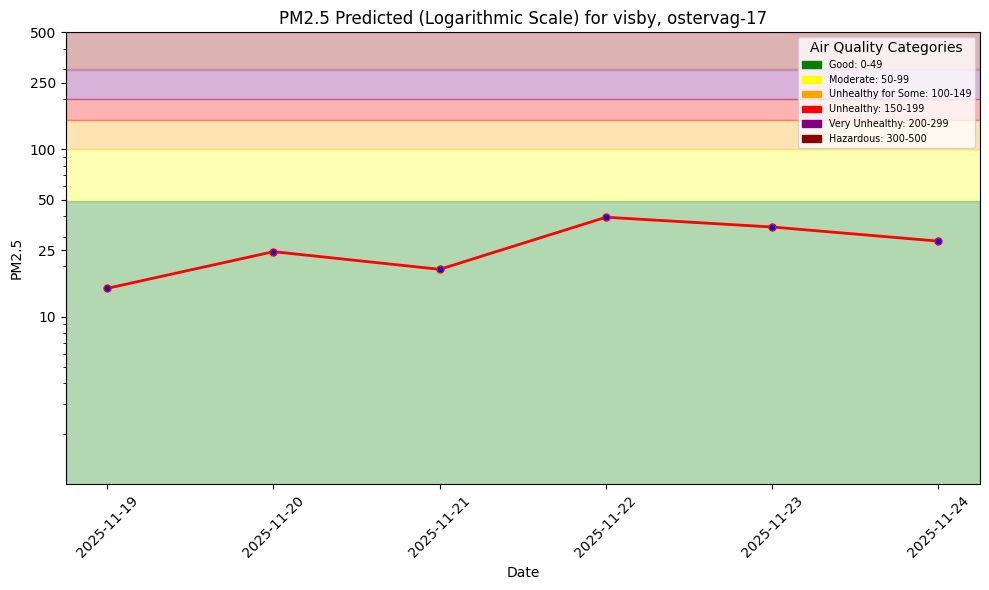

In [43]:
pred_file_path_v2 = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_v2.png"

plt = util.plot_air_quality_forecast(
    city,
    street,
    batch_data_v2,
    pred_file_path_v2,
)
plt.show()

In [44]:
monitoring_df_v2 = monitor_fg_v2.read()
monitoring_df_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.85s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1d_ago,pm25_2d_ago,pm25_3d_ago,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,1.55,0.0,3.600000,360.000000,visby,11.000000,4.000000,6.000000,14.772053,ostervag-17,sweden,1
1,2025-11-23 00:00:00+00:00,3.10,0.0,6.696387,233.746063,visby,39.289909,19.187738,24.468515,34.349468,ostervag-17,sweden,5
2,2025-11-20 00:00:00+00:00,1.35,0.8,6.214563,100.007919,visby,14.772053,11.000000,4.000000,24.468515,ostervag-17,sweden,2
3,2025-11-22 00:00:00+00:00,1.95,0.0,9.726664,218.990997,visby,19.187738,24.468515,14.772053,39.289909,ostervag-17,sweden,4
4,2025-11-24 00:00:00+00:00,3.95,0.1,10.495713,67.833611,visby,34.349468,39.289909,19.187738,28.278509,ostervag-17,sweden,6
5,2025-11-21 00:00:00+00:00,3.05,0.2,16.800856,315.000092,visby,24.468515,14.772053,11.000000,19.187738,ostervag-17,sweden,3


In [45]:
outcome_df_v2 = air_quality_df_v2[['date', 'pm25']]
outcome_df_v2

,date,pm25
731,2022-09-05 00:00:00+00:00,11.0
177,2022-09-06 00:00:00+00:00,9.0
464,2022-09-07 00:00:00+00:00,9.0
101,2022-09-08 00:00:00+00:00,10.0
1044,2022-09-09 00:00:00+00:00,18.0
...,...,...
570,2025-11-14 00:00:00+00:00,7.0
1095,2025-11-15 00:00:00+00:00,7.0
366,2025-11-16 00:00:00+00:00,6.0
1142,2025-11-17 00:00:00+00:00,4.0


In [46]:
outcome_df_v2 = air_quality_df_v2[['date', 'pm25']]
preds_df_v2 =  monitoring_df_v2[['date', 'predicted_pm25']]

hindcast_df_v2 = pd.merge(preds_df_v2, outcome_df_v2, on="date")
hindcast_df_v2 = hindcast_df_v2.sort_values(by=['date'])

hindcast_df_v2

,date,predicted_pm25,pm25


In [ ]:
hindcast_file_path_v2 = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_v2.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df_v2, hindcast_file_path_v2, hindcast=True)
plt.show()

---